In [1]:
import os
import socket
from timeit import default_timer as timer
from glob import glob
import pandas as pd
import pyarrow.parquet as pq

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
country_code = "US"
print('Country:', country_code)

Country: US


In [3]:
# Local
print('Hostname:', socket.gethostname())
if  'samuel' in socket.gethostname().lower():
    path_to_data='../../data'
# Cluster
else:
    path_to_data='/scratch/spf248/twitter/data'
    
path_to_mentions=os.path.join(path_to_data,'mentions',country_code)
path_to_official_data=os.path.join(path_to_data,'official')
print(path_to_mentions)
print(path_to_official_data)

Hostname: c09-03
/scratch/spf248/twitter/data/mentions/US
/scratch/spf248/twitter/data/official


# Twitter Labor Market Indicators

In [4]:
print('Import Mentions Counts')
start = timer()

mentions=pq.ParquetDataset(glob(os.path.join(path_to_mentions,'*.parquet'))).read().to_pandas()
print('# obs:', mentions.shape[0])

print("Done in", round(timer()-start), "sec")

Import Mentions Counts
# obs: 5501126
Done in 2 sec


In [5]:
mentions.head()

,year,month,user_location,n_users,n_hire,n_offer,n_loss,n_unemployed,n_search
0,2012,3,Bakersfield,100,0,0,0,0,0
1,2015,9,MISSISSIPPI,33,0,0,0,0,0
2,2014,1,"Tampa, FL",2618,0,10,0,0,0
3,2016,12,,35503,0,13,2,2,25
4,2016,11,"Boca Raton, FL",861,0,3,0,0,0


In [6]:
mentions.filter(regex='n_').sum()

n_users         157950183
n_hire               4327
n_offer            309501
n_loss               7541
n_unemployed         4529
n_search            68615
dtype: int64

# Twitter Account Locations Geocoded

In [7]:
locations=pd.read_pickle(os.path.join(path_to_data,'locations','profiles','account-locations.pkl'))

locations=locations[
locations.country_short==country_code].drop(
['n_users','latitude','longitude'],1).reset_index(drop=True)

In [8]:
locations.head()

,user_location,country_long,country_short,locality_long,locality_short,administrative_area_level_1_long,administrative_area_level_1_short,administrative_area_level_2_long,administrative_area_level_2_short
0,New York,United States,US,New York,New York,New York,NY,NaN,NaN
1,Los Angeles,United States,US,Los Angeles,Los Angeles,California,CA,Los Angeles County,Los Angeles County
2,"Los Angeles, CA",United States,US,Los Angeles,Los Angeles,California,CA,Los Angeles County,Los Angeles County
3,Chicago,United States,US,Chicago,Chicago,Illinois,IL,Cook County,Cook County
4,"New York, NY",United States,US,New York,New York,New York,NY,NaN,NaN


# Labor Market Statistics

In [9]:
surveys=pd.read_csv(os.path.join(path_to_official_data,'surveys',country_code+'.csv'))

In [10]:
surveys.head()

,year,month,quarter,administrative_area_level_1,administrative_area_level_2,urban_or_rural,unemployed,employed
0,1990,1,1,AL,Autauga County,Both,6.4,NaN
1,1990,2,1,AL,Autauga County,Both,6.6,NaN
2,1990,3,1,AL,Autauga County,Both,5.8,NaN
3,1990,4,2,AL,Autauga County,Both,6.6,NaN
4,1990,5,2,AL,Autauga County,Both,6.0,NaN


In [11]:
aggregates=pd.read_csv(os.path.join(path_to_official_data,'aggregates','monthly.csv'))

In [12]:
aggregates.head()

,date,BR,CL,CO,MX,MY,PE,TH,US,VE
0,2010-01-31,NaN,9.904,14.6,5.76,3.5,9.3,1.40,10.6,10.2
1,2010-02-28,NaN,9.330,12.6,5.28,3.5,10.5,1.00,10.4,8.6
2,2010-03-31,NaN,9.228,11.8,4.74,3.5,7.7,0.96,10.2,8.7
3,2010-04-30,NaN,8.836,12.2,5.35,3.0,8.8,1.18,9.5,8.2
4,2010-05-31,NaN,9.088,12.0,5.00,3.3,6.7,1.54,9.3,8.1


# Country-level Time Series

In [13]:
mentions=pd.merge(mentions,locations[['user_location']]).drop('user_location',1)
mentions=mentions.groupby(['year','month'],as_index=False).sum()
mentions.year=mentions.year.astype(int)
mentions.month=mentions.month.astype(int)
mentions.sort_values(by=['year','month'],inplace=True)
mentions=mentions[mentions.year<2020].copy()

In [14]:
aggregates=aggregates[['date',country_code]].copy()
aggregates['year']=aggregates['date'].map(lambda x:pd.to_datetime(x).year)
aggregates['month']=aggregates['date'].map(lambda x:pd.to_datetime(x).month)
aggregates.rename(columns={country_code:'unemployment'},inplace=True)
aggregates.drop('date',1,inplace=True)

In [15]:
df=pd.merge(aggregates,mentions)
df=pd.concat([
df.drop(df.filter(regex='n_').columns,1),
df.filter(regex='n_').divide(df.n_users,axis=0).drop('n_users',1)],1)
df['date']=df[['year','month']].apply(lambda x:'-'.join([str(y) for y in x]),1)
df[df.filter(regex='n_').columns]=df[df.filter(regex='n_').columns]*1000000

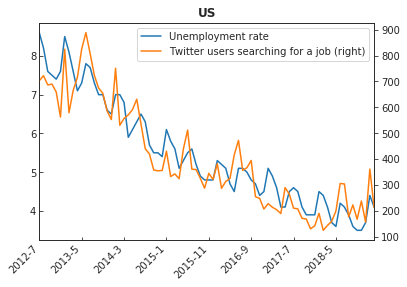

In [16]:
with sns.axes_style("white"):
    sns.set_style("ticks")
    
    fig,ax=plt.subplots()
    df.iloc[30:110].plot(ax=ax,y='unemployment',x='date',label='Unemployment rate')
    df.iloc[30:110].plot(ax=ax,y='n_search',secondary_y=True,x='date',label='Twitter users searching for a job')
    ax.set_xlabel('')
    ax.tick_params(which='both',direction='in',pad=3)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')
    ax.set_title(country_code,fontweight='bold')